# Restricted Boltzmann Machines

For a detailed presentation, refer to the section '**1.4 Boltzmann Machines**' in the file *MachineLearningOverview.pdf*, which is included in the same repository as this notebook.

A restricted Boltzmann machine (RBM) is a generative stochastic artificial neural network that can be used for unsupervised learning tasks, such as dimensionality reduction, feature learning, collaborative filtering and topic modeling. RBMs are particularly useful for modeling complex distributions of high-dimensional data, such as images, speech signals, and genomic data and have been successfully applied in a wide range of fields, including computer vision, speech recognition, natural language processing and bioinformatics. RBMs are also used as building blocks for more complex deep learning models, such as deep belief networks and deep autoencoders, which are used for tasks like image and text generation and anomaly detection. They can extract features of some dataset and the output can be used in a supervised model like linear regression or support vector machines for classification.

A RBM with 3 visible units and 7 hidden units is presented below:

<img src="./images/rbm.drawio.png" width="60%" align="center">

We will use the *Fashion-MNIST dataset* in order to train a RBM to generate synthetic data that resembles the samples of this dataset. The Fashion-MNIST dataset is a benchmark dataset commonly used in the field of computer vision for image classification tasks. It was created as a more challenging alternative to the popular MNIST dataset, which consists of grayscale images of handwritten digits. It consists of 70,000 grayscale images of size 28x28 pixels, which are divided into 60,000 training images and 10,000 testing images. Each image in the dataset belongs to one of 10 different classes representing different types of clothing and accessories, including T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags and ankle boots.

**Remark**: The code was kindly provided by my friend Antonios Kastellakis who implemeted this in the context of his thesis, where he trained an RBM to generate synthetic data of the MNIST dataset of hand-written digits. You can find his thesis *'Analog and Digital Quantum Neural Networks: Basic Concepts and Applications'* at http://dimitrisangelakis.org/theses/

First, let us import the necessary packages and load the Fashion-MNIST dataset.

In [1]:
# hide tensorflow warnings on GPU execution (we will use CPU)
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow import keras
from keras.datasets import fashion_mnist
from matplotlib import pyplot as plt
import numpy as np
import time

# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Print the shape of the training data
print('Training data shape:', x_train.shape, y_train.shape)

# Print the shape of the testing data
print('Testing data shape:', x_test.shape, y_test.shape)

Training data shape: (60000, 28, 28) (60000,)
Testing data shape: (10000, 28, 28) (10000,)


Let us display some random samples from the dataset:

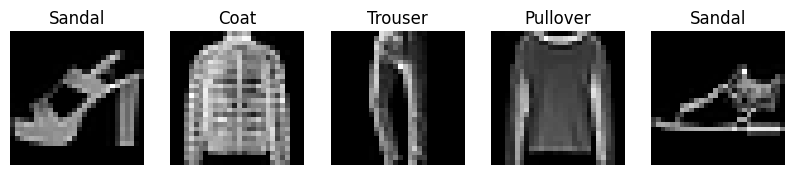

In [2]:
# Define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Generate a random sample of images to display
num_images = 5
rand_idx = np.random.randint(x_train.shape[0], size=num_images)

# Display the images and their labels
fig, axes = plt.subplots(1, num_images, figsize=(10,10))
for i, ax in enumerate(axes):
    ax.imshow(x_train[rand_idx[i]], cmap='gray')
    ax.set_title(class_labels[y_train[rand_idx[i]]])
    ax.axis('off')

plt.show()

Then, we reshape the data into arrays and move to normalization (pre-processing) and definition of the RBM hyperparameters.

In [3]:
training_data = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
test_data = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

# Print the shape of the reshaped training data
print('Reshaped training data shape:', training_data.shape)

# Print the shape of the reshaped testing data
print('Reshaped testing data shape:', test_data.shape)

Reshaped training data shape: (60000, 784)
Reshaped testing data shape: (10000, 784)


In [4]:
# normalize
threshold = 128
training_data = (training_data > np.ones(training_data.shape)*threshold)*1
test_data = (test_data > np.ones(test_data.shape)*threshold)*1

# define model hyperparameters
num_visible = training_data.shape[1]  # number of visible units corresponds to number of features
num_hidden = 200  # number of hidden units is set to 100 (sufficient)

# define training parameters
epochs = 50
# for datasets containing small number of equiprobable classes, 
# the ideal mini-batch size for contrastive divergence equals to the number of classes
batch_size = 10
# learning rate (adaptive with respect to the number of batch size)
eta = 0.1/batch_size

Now, we define the RBM class that implements the model that we will train:

In [5]:
class RBM(object):
    # class constructor
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        # initialize randomly the biases with a Gaussian of mean 0 and standard deviation 1
        self.a = np.random.normal(loc=0, scale=1, size=(1, num_visible))
        self.b = np.random.normal(loc=0, scale=1, size=(1, num_hidden))
        # initialize the weight matrix with a Gaussian of mean 0 and standard deviation 0.01
        self.weights = np.random.normal(loc=0, scale=0.01, size=(num_visible, num_hidden))
        # the following parameters are used to implement momentum in training as Hinton suggests
        self.w_inc = np.zeros(self.weights.shape)
        self.a_inc = np.zeros(self.a.shape)
        self.b_inc = np.zeros(self.b.shape)
        
    # training process
    def train_RBM(self, training_data, epochs, mini_batch_size, eta):
        # the goal for our model is to generate synthetic data
        # the model is trained using the Contrastive Divergence algorithm by Hinton
        
        for epoch in range(epochs):
            # shuffle the training data and partition it into mini-batches
            error = 0
            training_data_size = len(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0,training_data_size,mini_batch_size)]
            for batch in mini_batches:
                err = self.Contrastive_Divergence(batch, mini_batch_size, epoch, eta)
                error += err
                
            print('Epoch %s completed. Reconstruction error is %0.2f' % (epoch+1, error))
        
        avg_error = error/training_data_size
        print('\nTraining completed. Average reconstruction error is %0.2f' % avg_error)
        
    # Contrastive divergence (mini-batch) algorithm
    def Contrastive_Divergence(self, v0, mini_batch_size, epoch, eta):
        
        ## positive phase of contrastive divergence (data driven phase)
        z_h0 = np.dot(v0, self.weights) + np.tile(self.b, (v0.shape[0],1))
        prob_h0 = self.sigmoid(z_h0)
        
        # sample the states of hidden units based on prob_h0
        h0 = prob_h0 > np.random.rand(v0.shape[0], self.num_hidden)
        
        # positive phase product for updating the weights
        # using probability instead of the sampled hidden states usually has less sampling noise --> faster learning
        vihj_data = np.dot(v0.T, prob_h0)
        
        # values needed to update the biases
        vi_data = np.sum(v0, axis=0)
        hj_data = np.sum(prob_h0, axis=0)
        
        ## negative phase of contrastive divergence (reconstruction driven phase)
        # reconstruct the visible states from hidden states
        z_v1 = np.dot(h0, self.weights.T) + np.tile(self.a, (h0.shape[0],1))
        v1 = self.sigmoid(z_v1)
        
        # sample the hidden states from the visible states
        z_h1 = np.dot(v1, self.weights) + np.tile(self.b, (v1.shape[0],1))
        prob_h1 = self.sigmoid(z_h1)
        
        # negative phase products for updating the weights
        vihj_model = np.dot(v1.T, prob_h1)
        
        # values needed to update the biases
        vi_model = np.sum(v1, axis=0)
        hj_model= np.sum(prob_h1, axis=0)
        
        # set momentum as per Hinton's practical guide to training RBMs
        m = 0.5 if epoch > 5 else 0.9
        
        self.w_inc = self.w_inc*m + (eta/mini_batch_size)*(vihj_data - vihj_model)
        self.a_inc = self.a_inc*m + (eta/mini_batch_size)*(vi_data - vi_model)
        self.b_inc = self.b_inc*m + (eta/mini_batch_size)*(hj_data - hj_model)
        
        # update the weights and biases
        self.weights += self.w_inc
        self.a += self.a_inc
        self.b += self.b_inc
        
        err = np.sum((v0-v1)**2)/mini_batch_size
        
        return err
    
    def Reconstruct(self, V_data, recon_setps):
        # reconstruct the input vector
        # sample hidden states from the input vector and then sample visible states from hidden states
        # returns a vector of dimensions: 1 x num_visible
        
        V_rec = np.copy(V_data)
        
        for i in range(recon_setps):
            z = np.dot(V_rec, self.weights) + self.b
            prob_h = self.sigmoid(z)
            h = prob_h > np.random.rand(1, self.num_hidden)
            
            z_v1 = np.dot(h, self.weights.T) + self.a
            
            V_rec = self.sigmoid(z_v1)
            
        return V_rec
    
    # the sigmoid function
    def sigmoid(self, z):
        sig =  1.0/(1.0 + np.exp(-z))
        return sig

At last, we are ready to train the RBM.

In [6]:
rbm = RBM(num_visible, num_hidden)

start_time = time.time()
rbm.train_RBM(training_data, epochs, batch_size, eta)
exec_time = time.time() - start_time
print(f"Training time for {epochs} epochs, {num_hidden} hidden units and learning rate of {eta} :--- {exec_time} seconds ---")

Epoch 1 completed. Reconstruction error is 239981.06
Epoch 2 completed. Reconstruction error is 179124.30
Epoch 3 completed. Reconstruction error is 170326.69
Epoch 4 completed. Reconstruction error is 166201.01
Epoch 5 completed. Reconstruction error is 163907.54
Epoch 6 completed. Reconstruction error is 162248.15
Epoch 7 completed. Reconstruction error is 151429.74
Epoch 8 completed. Reconstruction error is 150269.58
Epoch 9 completed. Reconstruction error is 149858.14
Epoch 10 completed. Reconstruction error is 149553.71
Epoch 11 completed. Reconstruction error is 149224.29
Epoch 12 completed. Reconstruction error is 148940.65
Epoch 13 completed. Reconstruction error is 148655.50
Epoch 14 completed. Reconstruction error is 148414.27
Epoch 15 completed. Reconstruction error is 148191.17
Epoch 16 completed. Reconstruction error is 148000.60
Epoch 17 completed. Reconstruction error is 147833.26
Epoch 18 completed. Reconstruction error is 147624.79
Epoch 19 completed. Reconstruction er

We should note here that reconstruction error is not representative, but we want to keep track on the training process in terms of convergence. In summary, to count the error and track the training process of an RBM that uses the Contrastive Divergence algorithm, we need to compute the reconstruction error of the model after each training iteration and monitor the trend of the error over time.

### Generate synthetic data with the RBM

Now, we will use the RBM to generate synthetic data given samples from the test dataset.

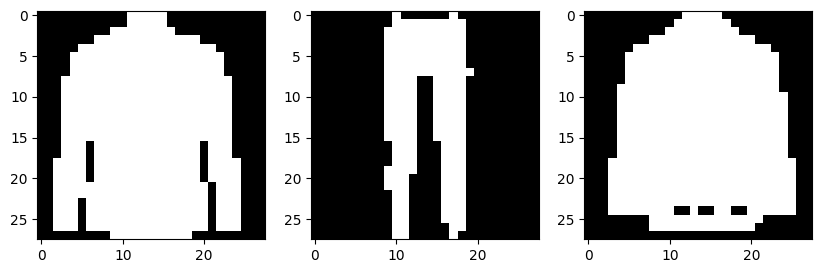

In [27]:
# choose 3 random samples from test dataset
sample_1 = test_data[np.random.randint(0, len(test_data)-1)]
sample_2 = test_data[np.random.randint(0, len(test_data)-1)]
sample_3 = test_data[np.random.randint(0, len(test_data)-1)]
# reshape
im_1 = np.reshape(sample_1, (28, 28))
im_2 = np.reshape(sample_2, (28, 28))
im_3 = np.reshape(sample_3, (28, 28))
# display
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(im_1, cmap='gray')
ax[1].imshow(im_2, cmap='gray')
ax[2].imshow(im_3, cmap='gray')
plt.show()

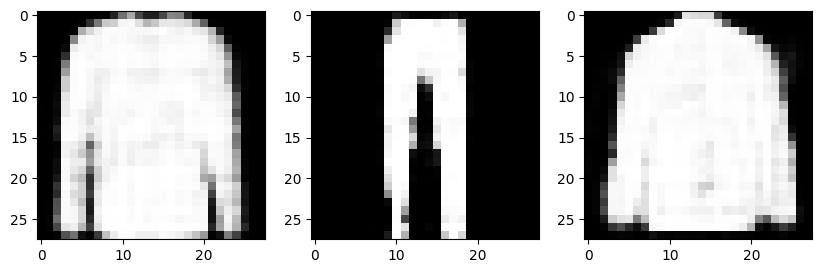

In [28]:
# reconstruct the images with the RBM
rbm_sample_1 = rbm.Reconstruct(sample_1, 10)
rbm_sample_2 = rbm.Reconstruct(sample_2, 10)
rbm_sample_3 = rbm.Reconstruct(sample_3, 10)

# reshape and display
rbm_im_1 = np.reshape(rbm_sample_1, (28, 28))
rbm_im_2 = np.reshape(rbm_sample_2, (28, 28))
rbm_im_3 = np.reshape(rbm_sample_3, (28, 28))
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(rbm_im_1, cmap='gray')
ax[1].imshow(rbm_im_2, cmap='gray')
ax[2].imshow(rbm_im_3, cmap='gray')
plt.show()

One advantage of using RBMs for synthetic data generation is that they can learn a compressed representation of the input data, which can help to reduce the dimensionality of the data and remove noisy or irrelevant features. This can be particularly useful for applications such as image generation, where the high-dimensional nature of the input data can make it difficult to generate high-quality synthetic images. However, it is important to keep in mind that RBMs are just one of many possible approaches for synthetic data generation and their effectiveness will depend on the specific characteristics of the input data and the requirements of the application. It may be useful to experiment with different generative models and techniques to find the best approach for some particular use case.

### Differences between MNIST and Fashion-MNIST

One key difference between MNIST and Fashion-MNIST is the complexity of the classification task. While MNIST consists of simple, uniform images of handwritten digits, Fashion-MNIST includes more diverse and complex images of clothing and accessories, with variations in texture, shape, and style. This makes the task of classifying the images in Fashion-MNIST more challenging than the task in MNIST.

Another difference between the two datasets is their relevance to real-world applications. MNIST has been used for decades as a standard benchmark for image classification tasks, but its practical applications are limited. Fashion-MNIST, on the other hand, was designed to be a more realistic and challenging dataset that better reflects the types of images encountered in real-world computer vision applications, such as e-commerce and fashion recommendation systems.